# ISIDORA

When a man rides a long time through wild regions he feels the desire for a city. Finally he comes to Isidora, a city where the buildings have spiral staircases encrusted with spiral seashells, where perfect telescopes and violins are made, where the foreigner hesitating between two women always encounters a third, where cockfights degenerate into bloody brawls among the bettors. He was thinking of all these things when he desired a city. Isidora, therefore, is the city of his dreams: with one difference. The dreamed-of city contained him as a young man; he arrives at Isidora in his old age. In the square there is the wall where the old men sit and watch the young go by; he is seated in a row with them. Desires are already memories.

In [1]:
from __future__ import print_function
from IPython.display import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


1. reads a file containing MCRDST data
2. Creates Panda DF to describe the PMT and SiPM metadata
3. Creates a Panda DF to store the energy (in PES) of each PMT for each event
4. Simulates response of the EP FEE and decimates waveforms according to DAQ
5. Writes a new Nh5 DST

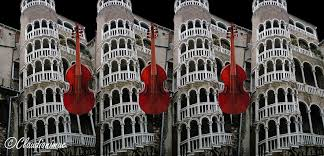

In [2]:
Image(filename='../Images/Isidora.jpg') 

In [3]:
import pandas as pd
import tables as tb
import numpy as np

In [4]:
from system_of_units import *

In [5]:
from PlotUtil import *

### DBLR

#### Reaout RWF DST

In [6]:
h5f = tb.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_0_RWF.h5', "a") 

In [7]:
pmtrd_ = h5f.root.RD.pmtrd

In [8]:
pmtrd_.shape

(99, 12, 24000)

In [9]:
signal_t = np.arange(0.0, pmtrd_.shape[2]*1., 1., dtype=np.double)

In [10]:
import FEParam as FP

In [11]:
from scipy import signal as SGN

### Deconvolution function

In [12]:

def BLR(signal_daq, coef, n_sigma = 3, NOISE_ADC=0.7, 
        thr1 = 0, thr2 = 0, thr3 = 0, plot = False, log='DEBUG'):
    """
    Deconvolution offline of the DAQ signal using a MAU
    moving window-average filter of a vector data
    y(n) = (1/WindowSize)(x(n) + x(n-1) + ... + x(n-windowSize))
    in a filter operation filter(b,a,x):
    b = (1/WindowSize)*ones(WindowSize) = (1/WS)*[1,1,1,...]: numerator
    a = 1 : denominator
    y = filter(b,a,x)
    y[0] = b[0]*x[0] = (1/WS) * x[0]
    y[1] = (1/WS) * (x[0] + x[1])
    y[WS-1] = mean(x[0:WS])
    y[WS] = mean(x[1:WS+1])
    and so on
    """
    import logging
    logl ='logging.'+log
    logging.basicConfig(level=eval(logl))
    
    MAU_WindowSize = FP.MAU_WindowSize
    time_DAQ = FP.time_bin

    len_signal_daq = len(signal_daq)
    MAU = np.zeros(len_signal_daq, dtype=np.double)
    acum = np.zeros(len_signal_daq, dtype=np.double)
    signal_r = np.zeros(len_signal_daq, dtype=np.double)
    pulse_f = np.zeros(len(signal_daq), dtype=np.double)
    pulse_ff = np.zeros(len(signal_daq), dtype=np.double)
    pulse_t = np.zeros(len(signal_daq), dtype=np.double)
    pulse_w = np.zeros(len(signal_daq), dtype=np.double)
    
    signal_i = np.copy(signal_daq) #uses to update MAU while procesing signal


    thr = n_sigma*NOISE_ADC
    if thr1 != 0:
        thr = thr1

    thr_tr = thr/5. # to conclude BLR when signal_deconv = signal_raw

    if thr3 != 0:
        thr_tr = thr3
    
    nm = MAU_WindowSize
    B_MAU       =   (1./nm)*np.ones(nm)

#   MAU averages the signal in the initial tranch 
#    allows to compute the baseline of the signal  
    
    MAU[0:nm] = SGN.lfilter(B_MAU,1, signal_daq[0:nm])
    acum[nm] =  MAU[nm]
    BASELINE = MAU[nm-1]

    logging.debug("""-->BLR:: n_sigma = {}, NOISE_ADC= {}, 
        thr1 = {}, thr2 = {}, thr3 = {} =""".format(
            n_sigma, NOISE_ADC, thr1, thr2, thr3))

    if plot:
        logging.debug("n = {}, acum[n] = {} BASELINE ={}".format(nm, acum[nm],BASELINE))

        ax1 = plt.subplot(3,1,1)
        ax1.set_xlim([0, nm])
        plt.plot(MAU)
        plt.show()

#----------

# While MAU inits BLR is switched off, thus signal_r = signal_daq 

    signal_r[0:nm] = signal_daq[0:nm] 
    pulse_on=0
    wait_over=0
    offset = 0

    # MAU has computed the offset using nm samples
    # now loop until the end of DAQ window

    for k in range(nm,len_signal_daq): 

        trigger_line = MAU[k-1] + thr
        pulse_t[k] = trigger_line
        pulse_f[k] = pulse_on
        pulse_w[k] = wait_over 
        pulse_ff[k] = signal_daq[k] - signal_r[k]

        # condition: raw signal raises above trigger line and 
        # we are not in the tail
        # (wait_over == 0)
        if signal_daq[k] > trigger_line and wait_over == 0:

            # if the pulse just started pulse_on = 0.
            # In this case compute the offset as value 
            #of the MAU before pulse starts (at k-1)

            if pulse_on == 0: # pulse just started
                #offset computed as the value of MAU before pulse starts
                offset = MAU[k-1]  
                pulse_on = 1 

            #Freeze the MAU
            MAU[k] = MAU[k-1]  
            signal_i[k] =MAU[k-1]  #signal_i follows the MAU
            
            #update recovered signal, correcting by offset
            acum[k] = acum[k-1] + signal_daq[k] - offset;
            signal_r[k] = signal_daq[k] + coef*acum[k] 
            
        else:  #raw signal just dropped below threshold
        # but raw signal can be negative for a while and still contribute to the
        # reconstructed signal.

            if pulse_on == 1: #reconstructed signal still on
            # switch the pulse off only when recovered signal 
            #drops below threshold
                
                #slide the MAU, still frozen. 
                # keep recovering signal
                MAU[k] = MAU[k-1]  
                signal_i[k] =MAU[k-1]
                acum[k] = acum[k-1] + signal_daq[k] - offset;
                signal_r[k] = signal_daq[k] + coef*acum[k] 
            
                #if the recovered signal drops before trigger line 
                #rec pulse is over!
                if signal_r[k] < trigger_line + thr2:
                    wait_over = 1  #start tail compensation
                    pulse_on = 0   #recovered pulse is over

            else:  #recovered signal has droped below trigger line
            #need to compensate the tail to avoid drifting due to erros in 
            #baseline calculatoin

                if wait_over == 1: #compensating pulse
                    # recovered signal and raw signal 
                    #must be equal within a threshold
                    # otherwise keep compensating pluse


                    if signal_daq[k-1] < signal_r[k-1] - thr_tr:
                        # raw signal still below recovered signal 

                        # is the recovered signal near offset?
                        upper = offset + (thr_tr + thr2)
                        lower = offset - (thr_tr + thr2)

                        if signal_r[k-1] > lower and signal_r[k-1] < upper:
                            # we are near offset, activate MAU. 
                            #signal_i follows rec signal
                            
                            signal_i[k] = signal_r[k-1]
                            MAU[k] = np.sum(signal_i[k-nm:k])/nm

                        else: 
                            # rec signal not near offset MAU frozen 
                                
                            MAU[k] = MAU[k-1]
                            signal_i[k] = MAU[k-1]

                        # keep adding recovered signal until 
                        # it raises above the raw signal 

                        acum[k] = acum[k-1] + signal_daq[k] - MAU[k]
                        signal_r[k] = signal_daq[k] + coef*acum[k]

                    else:  # input signal above recovered signal: we are done
                        wait_over = 0
                        acum[k] = MAU[k-1]
                        signal_r[k] = signal_daq[k]
                        signal_i[k] = signal_r[k]
                        MAU[k] = np.sum(signal_i[k-nm:k])/nm
                else:
                    wait_over = 0
                    acum[k] = MAU[k-1]
                    signal_r[k] = signal_daq[k]
                    signal_i[k] = signal_r[k]
                    MAU[k] = np.sum(signal_i[k-nm:k])/nm

    #energy = np.dot(pulse_f,(signal_r-BASELINE))*FP.time_DAQ
    energy = np.dot(pulse_f,(signal_r-BASELINE)) #already scaled in FEE2

    if plot:
        logging.debug("Baseline = {}, energy = {} ".format(BASELINE, energy))

        ax1 = plt.subplot(3,2,1)
        ax1.set_xlim([7000, 10000])
        plt.plot(pulse_f, color='red')

        ax2 = plt.subplot(3,2,2)
        ax2.set_xlim([7000, 10000])
        plt.plot(pulse_w, color='green')

        ax3 = plt.subplot(3,2,3)
        ax3.set_xlim([7000, 10000])
        plt.plot(pulse_ff, color='black')

        ax4 = plt.subplot(3,2,4)
        ax4.set_xlim([7000, 10000])
        plt.plot(signal_daq, color='yellow')

        ax5 = plt.subplot(3,2,5)
        plt.plot(signal_r-BASELINE)
        ax5.set_xlim([7000, 20000])

        ax5 = plt.subplot(3,2,6)
        plt.plot(pulse_t, color='orange')
        ax5.set_xlim([7000, 10000])

        plt.show()
                       
    return  signal_r-BASELINE, energy

#### Inverse signal

In [13]:
def inverse_signal(pmtrd_,signal_t, event_number,CA):
    """
    Peform Base line Restoration
    CA is an array with the values of the capacitances for the PMTs
    """
    import FEParam as FP
    import FEE2 as FE
    
    len_WF = pmtrd_.shape[2]
    NPMT = pmtrd_.shape[1]
    ene_pmt =np.zeros(len_WF, dtype=np.int32)
    
    inv = []
    for j in range(NPMT):
        pmtrd = pmtrd_[event_number, j] #waveform for event event_number, PMT j
        
        #Deconvolution
        fee = FE.FEE(C=CA[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        signal_inv_daq = fee.InverseSignalDAQ(signal_t)  #inverse function
        inv.append( signal_inv_daq)
    return pd.Series(inv)

In [14]:
idf = inverse_signal(pmtrd_,signal_t,event_number = 0, CA=FP.C12)

In [15]:
idf

0     [1.0008821504, 0.00176430079652, 0.00176430079...
1     [1.00085441719, 0.00170883437651, 0.0017088343...
2     [1.00087671552, 0.00175343104735, 0.0017534310...
3     [1.00085494967, 0.00170989934246, 0.0017098993...
4     [1.00084430984, 0.00168861968206, 0.0016886196...
5     [1.00087214571, 0.00174429142726, 0.0017442914...
6     [1.00086030101, 0.00172060201819, 0.0017206020...
7     [1.00085547749, 0.00171095498465, 0.0017109549...
8     [1.00085888793, 0.0017177758591, 0.00171777585...
9     [1.00084361486, 0.00168722971163, 0.0016872297...
10    [1.00085742975, 0.00171485949265, 0.0017148594...
11    [1.00084266276, 0.00168532552339, 0.0016853255...
dtype: object

In [16]:
def plot_inverse(wfdf):
    """
    plot the inverse function
    """
    
    plt.figure(figsize=(12,12))
    
    for i in range(12):
        wf = wfdf.ix[i]
        ax1 = plt.subplot(3,4,i+1)
        ax1.set_xlim([0, len(wf)])
        SetPlotLabels(xlabel='t (ns)', ylabel='adc')
        plt.plot(wf[1:])

    plt.show()

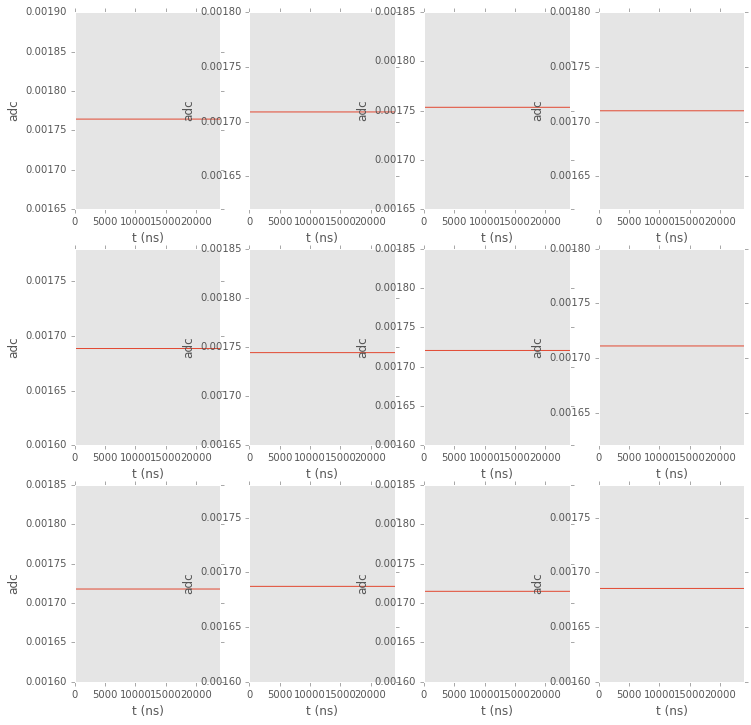

In [17]:
plot_inverse(idf)

### Digital Baseline

In [31]:
def DBLR(pmtrd_,signal_t, event_number, CA, nsigma=3, plot='True' ):
    """
    Peform Base line Restoration
    CA is an array with the values of the capacitances for the PMTs
    """
    import FEParam as FP
    import FEE2 as FE
    
    len_WF = pmtrd_.shape[2]
    NPMT = pmtrd_.shape[1]
    ene_pmt =np.zeros(NPMT, dtype=np.int32)
    coef_pmt =np.zeros(NPMT, dtype=np.double)
    
    PMTWF ={}
    
    for j in range(NPMT):

        pmtrd = pmtrd_[event_number, j] #waveform for event event_number, PMT j
        
        #Deconvolution
        fee = FE.FEE(C=CA[j],R= FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        signal_inv_daq = fee.InverseSignalDAQ(signal_t)  #inverse function
        coef = signal_inv_daq[10]  #accumulator coefficient
       
        signal_blr, eadc = BLR(pmtrd, coef, n_sigma = nsigma, 
                            NOISE_ADC=FP.NOISE_ADC, 
                            thr2=FP.NOISE_ADC/4., thr3 = FP.NOISE_ADC/2.,
                            plot=plot)
    
        ene_pmt[j] = eadc
        coef_pmt[j] = coef
        PMTWF[j]=signal_blr
       
    return pd.Series(ene_pmt), pd.Series(coef_pmt), pd.DataFrame(PMTWF)

In [22]:
import FEParam as FP

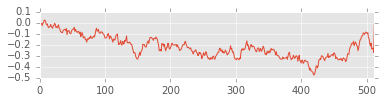

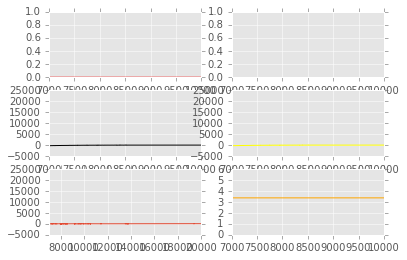

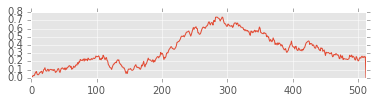

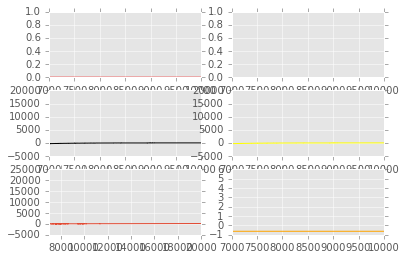

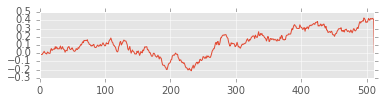

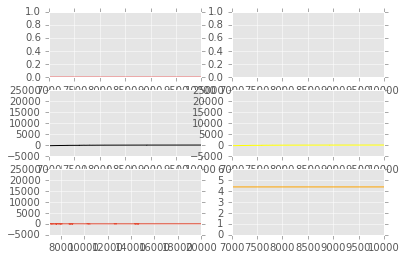

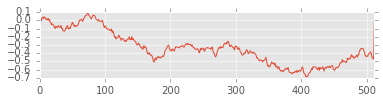

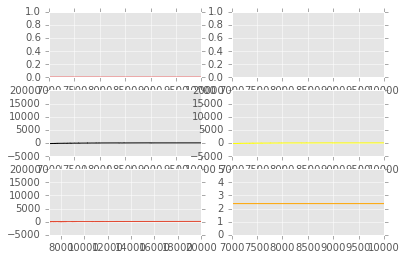

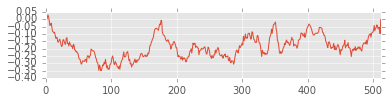

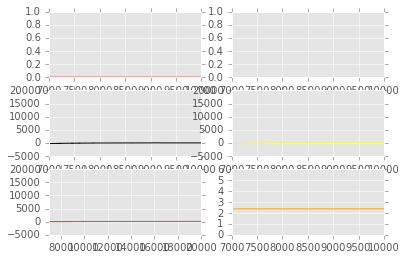

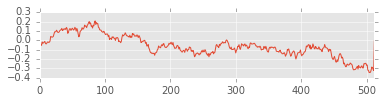

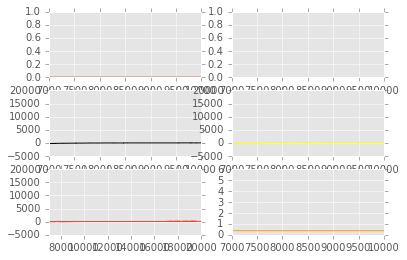

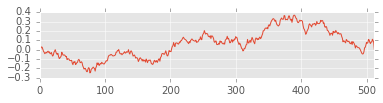

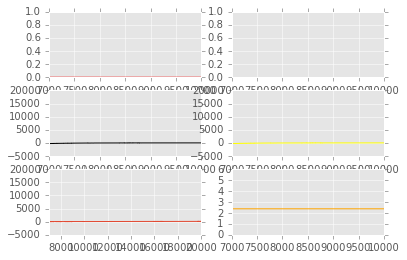

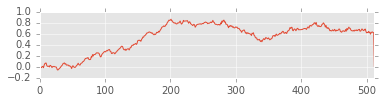

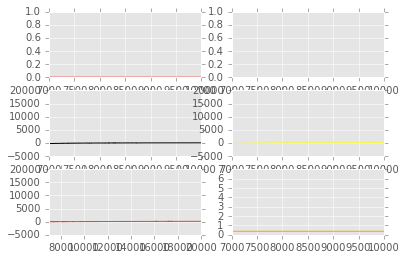

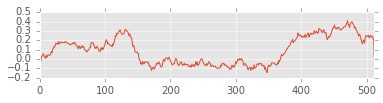

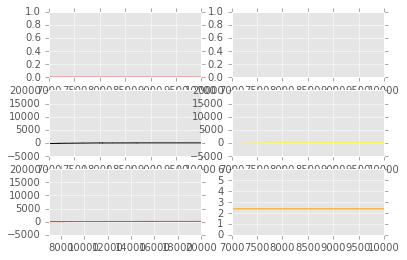

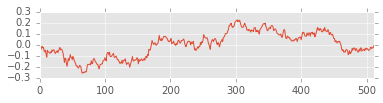

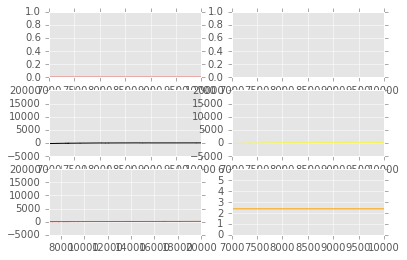

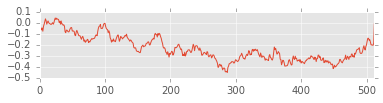

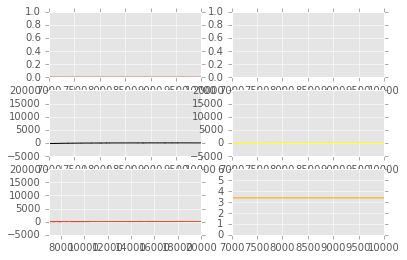

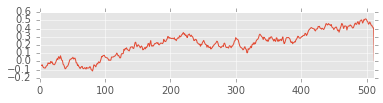

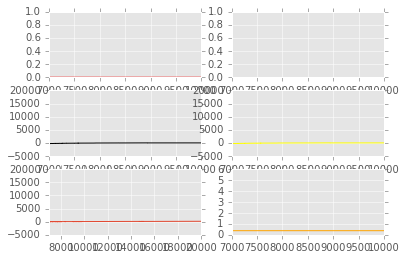

In [32]:
ene_pmt, ene_coef, PMTWF = DBLR(pmtrd_,signal_t, event_number=0, CA=FP.C12, nsigma=3, plot='True' )

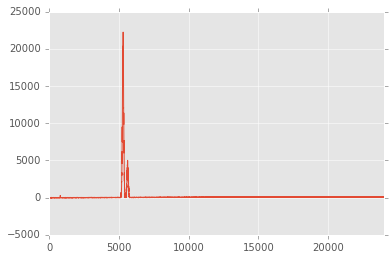

In [34]:
PMTWF[0].plot()

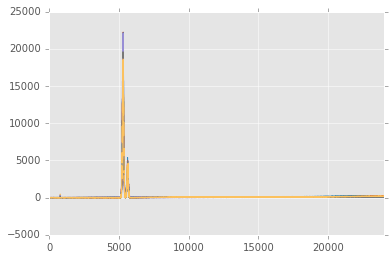

In [35]:
for i in range(12):
    PMTWF[i].plot()

In [36]:
ene_pmt

0         771
1     2307342
2         755
3         769
4        2242
5         887
6         842
7     1942111
8        1188
9        1018
10        663
11    1932283
dtype: int32

In [48]:
ene_pmt[0]

771

In [39]:
from PandaUtil import *

In [37]:
def plot_waveforms(pmtwfdf):
    """
    Takes as input a df storing the PMT wf and plots the 12 PMT WF
    """
    
    plt.figure(figsize=(12,12))
    
    len_pmt = len(pmtwfdf[0])
    for i in range(12):
        ax1 = plt.subplot(3,4,i+1)
        ax1.set_xlim([0, len_pmt])
        SetPlotLabels(xlabel='t (ns)', ylabel='adc')
        plt.plot(pmtwfdf[i])

    
    plt.show()

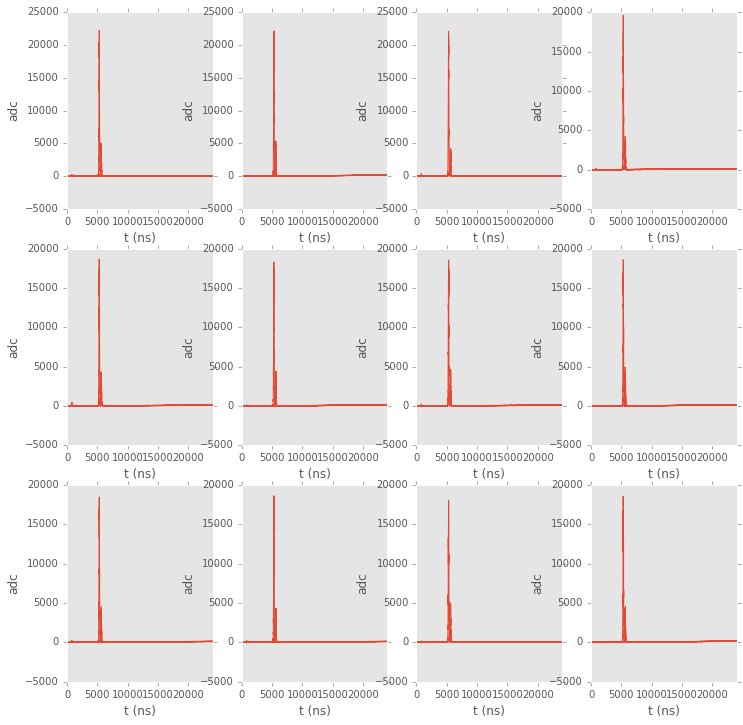

In [38]:
plot_waveforms(PMTWF)

In [41]:
geom_t = h5f.root.Detector.DetectorGeometry

In [42]:
geom_df = read_data_geom(geom_t)

In [43]:
geom_df

xdet_min   -198.0
xdet_max    198.0
ydet_min   -198.0
ydet_max    198.0
zdet_min      0.0
zdet_max    532.0
R           198.0
dtype: float64

In [44]:
pmt_t = h5f.root.Sensors.DataPMT
sipm_t = h5f.root.Sensors.DataSiPM

In [45]:
pmtdf = read_data_sensors(pmt_t)

In [46]:
sipmdf = read_data_sensors(sipm_t)

In [49]:
pmtdf

,active,adc_to_pes,channel,gain,x,y
0,1,20.0,0,4500000.0,23.9414,65.7785
1,1,20.0,1,4500000.0,-68.9365,-12.1554
2,1,20.0,2,4500000.0,44.9951,-53.6231
3,1,20.0,3,4500000.0,0.0000,185.0000
4,1,20.0,5,4500000.0,-118.9160,141.7180
5,1,20.0,6,4500000.0,-182.1890,32.1249
6,1,20.0,8,4500000.0,-160.2150,-92.5000
7,1,20.0,9,4500000.0,-63.2737,-173.8430
8,1,20.0,10,4500000.0,63.2737,-173.8430
9,1,20.0,12,4500000.0,160.2150,-92.5000


In [51]:
pmtdf['x'].values

array([  23.9414,  -68.9365,   44.9951,    0.    , -118.916 , -182.189 ,
       -160.215 ,  -63.2737,   63.2737,  160.215 ,  182.189 ,  118.916 ])

In [53]:
ene_pmt.values

array([    771, 2307342,     755,     769,    2242,     887,     842,
       1942111,    1188,    1018,     663, 1932283], dtype=int32)

In [54]:
def plot_ene_pmt(geom_df,sensor_df, energy_se, radius=10):
    """
    plots the reconstructed energy of the PMTs
    energy_se is a series describing the reconstructed energy 
    in each PMT
    """
    x =sensor_df['x'].values
    y =sensor_df['y'].values
    r =np.ones(len(sensor_df['x'].values))*radius
    col = energy_se.values 
    
    plt.figure(figsize=(10,10))
    ax = plt.subplot(aspect='equal')
    circles(x, y, r, c=col, alpha=0.5, ec='none')
    plt.colorbar()
    #xlim(-198,198)  #one should use geom info
    #ylim(-198,198)
    xlim(geom_df['xdet_min'],geom_df['xdet_max'])
    ylim(geom_df['ydet_min'],geom_df['ydet_max'])
    return col

array([    771, 2307342,     755,     769,    2242,     887,     842,
       1942111,    1188,    1018,     663, 1932283], dtype=int32)

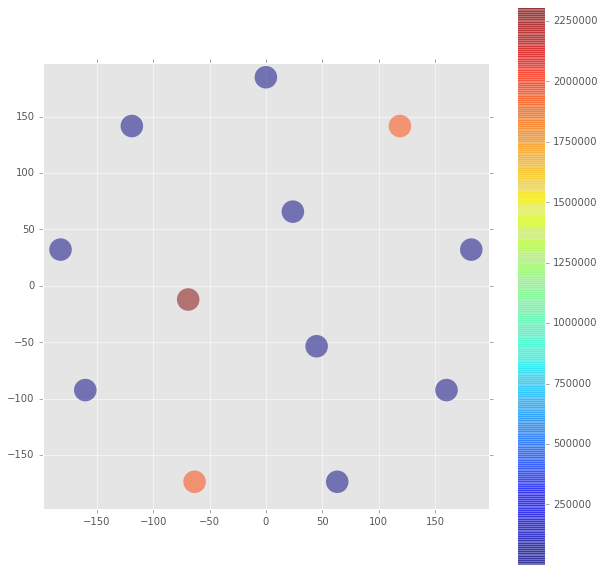

In [55]:
plot_ene_pmt(geom_df,pmtdf, ene_pmt, radius=10)

In [ ]:
def sipm_energy(sipmwf, indx=0):
    """
    returns an array with the energy of the SiPMs
    """
    sipm_WFS = sipmwf[indx]
    
    energy=[]
    for i in range(len(sipm_WFS)):
        sipm_wf = sipm_WFS[i]
        energy.append(np.sum(sipm_wf))
    return pd.Series(energy)